# Modeling
---

## Binary Classification
I am initiating this project with a binary classification approach. This foundational step is crucial, as the primary objective is to develop a model capable of flagging retinal images as abnormal for further review. Developing a multiclass model to identify specific diseases will be addressed subsequently.

Initially, I will construct a Convolutional Neural Network (CNN) from scratch to evaluate its performance. This will be compared against the pretrained ResNet152V2 and Xception models available in Keras. The default image size for ResNet152V2 is (224, 224, 3), therefore I will read in images at this size to ensure compatibility.

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import (Input, Rescaling, Conv2D, MaxPooling2D, BatchNormalization,
                                     Flatten, Dense, Dropout, GlobalAveragePooling2D, RandomRotation,
                                     RandomContrast)
from tensorflow.keras.metrics import TruePositives, FalseNegatives
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.applications.resnet_v2 import ResNet152V2, preprocess_input

from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# unzip image folder in my Google Drive
!unzip -q drive/MyDrive/dsb826-capstone-data/binary.zip

In [4]:
# load in images as train and validation sets
train_ds, val_ds = image_dataset_from_directory(
    'binary',
    image_size = (224, 224),
    batch_size = 16,
    label_mode = 'binary',
    seed = 42,
    validation_split = 0.3,
    subset = 'both',
)

# split validation into val and test sets
# method adapted from stack overflow
# https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

Found 12784 files belonging to 2 classes.
Using 8949 files for training.
Using 3835 files for validation.


In [5]:
# verify assigned classes
train_ds.class_names

['0', '1']

The negative 0 class is a normal retina and the positive 1 class is an abnormal retina with any condition/disease.

In [7]:
es = EarlyStopping(patience = 5, restore_best_weights = True)

model = Sequential()
model.add(Input((224, 224, 3)))
model.add(Rescaling(1./255))

model.add(Conv2D(512, (3, 3), padding = 'same', activation = 'relu'))
model.add(Conv2D(512, (3, 3), padding = 'same', activation = 'relu'))
model.add(Conv2D(512, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(256, (3, 3), padding = 'same', activation = 'relu'))
model.add(Conv2D(256, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(256, activation = 'relu', kernel_regularizer = l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(
    loss = 'bce',
    optimizer = 'adam',
    metrics = ['acc', TruePositives(), FalseNegatives()]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 224, 224, 512)       │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 224, 224, 512)       │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 224, 224, 512)       │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 512)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 112, 112, 256)       │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 112, 112, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 56, 56, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,232,129 (39.03 MB)

 Trainable params: 10,232,129 (39.03 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
res = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 30,
    callbacks = [es]
)

Epoch 1/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 244s 316ms/step - acc: 0.5370 - false_negatives_1: 46.5651 - loss: 1.3357 - true_positives_1: 2405.9126 - val_acc: 0.5592 - val_false_negatives_1: 0.0000e+00 - val_loss: 0.6876 - val_true_positives_1: 713.0000
Epoch 2/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 143s 256ms/step - acc: 0.5464 - false_negatives_1: 0.0000e+00 - loss: 0.6892 - true_positives_1: 2451.8503 - val_acc: 0.5592 - val_false_negatives_1: 0.0000e+00 - val_loss: 0.6869 - val_true_positives_1: 713.0000
Epoch 3/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 143s 256ms/step - acc: 0.5458 - false_negatives_1: 0.0000e+00 - loss: 0.6894 - true_positives_1: 2452.4224 - val_acc: 0.5592 - val_false_negatives_1: 0.0000e+00 - val_loss: 0.6868 - val_true_positives_1: 713.0000
Epoch 4/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 143s 256ms/step - acc: 0.5466 - false_negatives_1: 0.0000e+00 - loss: 0.6888 - true_positives_1: 2452.1604 - val_acc: 0.5592 - val_false_negatives_1: 0.0000e+00 - val_loss: 0.6868 - val_true_positives_1: 

In [9]:
res.history

{'acc': [0.5418482422828674,
  0.5437479019165039,
  0.5437479019165039,
  0.5437479019165039,
  0.5437479019165039,
  0.5437479019165039,
  0.5437479019165039,
  0.5437479019165039,
  0.5437479019165039,
  0.5437479019165039,
  0.5437479019165039,
  0.5437479019165039,
  0.5437479019165039,
  0.5437479019165039,
  0.5437479019165039],
 'false_negatives_1': [48.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'loss': [0.8790491223335266,
  0.6895679235458374,
  0.6896569132804871,
  0.6894639730453491,
  0.6895983219146729,
  0.6898127198219299,
  0.6896989345550537,
  0.6897249817848206,
  0.6895935535430908,
  0.6893749833106995,
  0.6895493865013123,
  0.689351499080658,
  0.6896361708641052,
  0.6895062327384949,
  0.6894485950469971],
 'true_positives_1': [4818.0,
  4866.0,
  4866.0,
  4866.0,
  4866.0,
  4866.0,
  4866.0,
  4866.0,
  4866.0,
  4866.0,
  4866.0,
  4866.0,
  4866.0,
  4866.0,
  4866.0],
 'val_acc': [0.5592156648

In [11]:
# calculate sensitivity
train_sensitivity = [i/(i+j) for i, j in zip(res.history['true_positives_1'], res.history['false_negatives_1'])]
val_sensitivity = [i/(i+j) for i, j in zip(res.history['val_true_positives_1'], res.history['val_false_negatives_1'])]

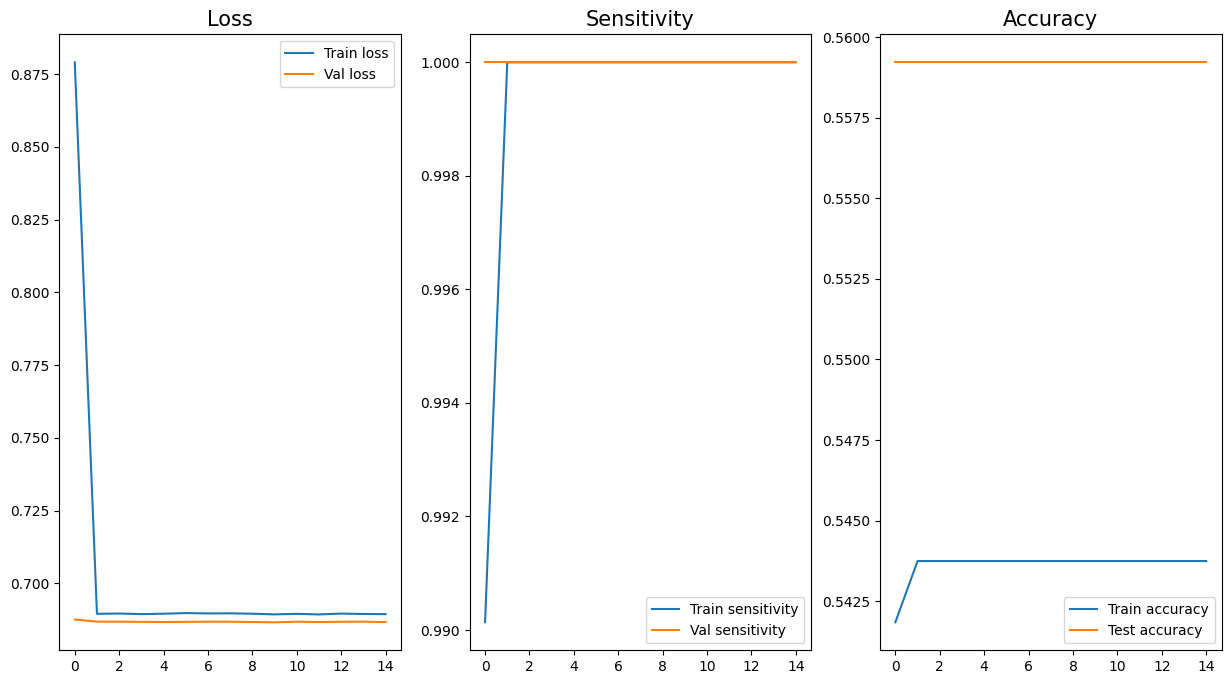

In [12]:
fig, ax = plt.subplots(1, 3, figsize = (15, 8))

ax[0].plot(res.history['loss'], label = 'Train loss')
ax[0].plot(res.history['val_loss'], label = 'Val loss')
ax[0].set_title('Loss', size = 15)
ax[0].legend(loc = 'best')

ax[1].plot(train_sensitivity, label = 'Train sensitivity')
ax[1].plot(val_sensitivity, label = 'Val sensitivity')
ax[1].set_title('Sensitivity', size = 15)
ax[1].legend(loc = 'best')

ax[2].plot(res.history['acc'], label = 'Train accuracy')
ax[2].plot(res.history['val_acc'], label = 'Test accuracy')
ax[2].set_title('Accuracy', size = 15)
ax[2].legend(loc = 'best');

After many adjustments to the above CNN, I was unable to train a model that beats the baseline accuracy of 55% and it is underfit. Instead of trying to build a more complex model I'm going to lean on the ResNet152V2 pretrained model through Keras next to try and improve performance. I'll start with the entire model being untrainable as a baseline.

In [ ]:
# methods below follow Tensorflow's tutorial on transfer learning
# https://www.tensorflow.org/tutorials/images/transfer_learning
base_model = ResNet152V2(input_shape = (224, 224, 3),
                         include_top = False,
                         weights = 'imagenet')

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

base_model.trainable = False

I'm using the image augmentation methods below to try and mimic some real world differences between retinal photos of patients. RandomRotation because everyone's anatomy of the back of the eye is slightly different and positioning of the macula and optic nerve is never going to be exactly the same, so the slight rotations should capture different angles of how diseases present on the retina. RandomContrast because some conditions show up as light spots on the retina and some are darker than the surrounding tissue so an increase/decrease in contrast would highlight those conditions.

In [ ]:
data_augmentation = Sequential([
    RandomRotation(0.1, seed = 42),
    RandomContrast(0.1, seed = 42)
])

In [ ]:
global_average_layer = GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
prediction_layer = Dense(1, activation = 'sigmoid')
prediction_batch = prediction_layer(feature_batch_average)

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)
x = Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_6 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_10 (TrueDivide)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_10 (Subtract)               │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet152v2 (Functional)             │ (None, 7, 7, 2048)          │      58,331,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_10          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,333,697 (222.53 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 58,331,648 (222.52 MB)

In [ ]:
model.compile(loss = 'bce', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              metrics = ['acc', TruePositives(), FalseNegatives()])

In [ ]:
es = EarlyStopping(patience = 5,
                   restore_best_weights = True)

model_checkpoint = ModelCheckpoint(filepath = 'best_binary_resnet_model.keras',
                                   monitor = 'val_loss',
                                   save_best_only = True,
                                   mode = 'min')

In [ ]:
res = model.fit(train_ds,
                epochs = 50,
                validation_data = val_ds,
                callbacks = [es, model_checkpoint])

Epoch 1/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 43s 50ms/step - acc: 0.5791 - false_negatives_8: 819.8842 - loss: 0.6843 - true_positives_8: 1632.7327 - val_acc: 0.6016 - val_false_negatives_8: 468.0000 - val_loss: 0.6811 - val_true_positives_8: 245.0000
Epoch 2/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - acc: 0.6304 - false_negatives_8: 810.8004 - loss: 0.6304 - true_positives_8: 1640.6453 - val_acc: 0.6667 - val_false_negatives_8: 314.0000 - val_loss: 0.5923 - val_true_positives_8: 399.0000
Epoch 3/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - acc: 0.6432 - false_negatives_8: 766.6292 - loss: 0.6102 - true_positives_8: 1684.4457 - val_acc: 0.6753 - val_false_negatives_8: 273.0000 - val_loss: 0.5828 - val_true_positives_8: 440.0000
Epoch 4/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - acc: 0.6613 - false_negatives_8: 764.2924 - loss: 0.6009 - true_positives_8: 1688.7878 - val_acc: 0.6392 - val_false_negatives_8: 403.0000 - val_loss: 0.6298 - val_true_positives_8: 310.0000
Epoch 5/50
5

In [ ]:
res.history

{'acc': [0.6035311222076416,
  0.6424181461334229,
  0.6467761993408203,
  0.6550452709197998,
  0.6600737571716309,
  0.6611911654472351,
  0.6657727360725403,
  0.6644317507743835,
  0.6658844351768494,
  0.671248197555542,
  0.6714716553688049,
  0.6647670269012451,
  0.667672336101532,
  0.6735948324203491,
  0.6677840948104858,
  0.6671136617660522,
  0.6723656058311462,
  0.6728125810623169,
  0.6767236590385437],
 'false_negatives_8': [1627.0,
  1597.0,
  1538.0,
  1537.0,
  1519.0,
  1541.0,
  1494.0,
  1505.0,
  1490.0,
  1510.0,
  1468.0,
  1512.0,
  1489.0,
  1467.0,
  1504.0,
  1501.0,
  1492.0,
  1464.0,
  1453.0],
 'loss': [0.6568038463592529,
  0.6211921572685242,
  0.6106677055358887,
  0.6078306436538696,
  0.602807879447937,
  0.6015000939369202,
  0.5988826751708984,
  0.5966195464134216,
  0.5934229493141174,
  0.5947405695915222,
  0.5902628898620605,
  0.5997257232666016,
  0.5916266441345215,
  0.5882412195205688,
  0.5892544984817505,
  0.5906517505645752,
  0.5

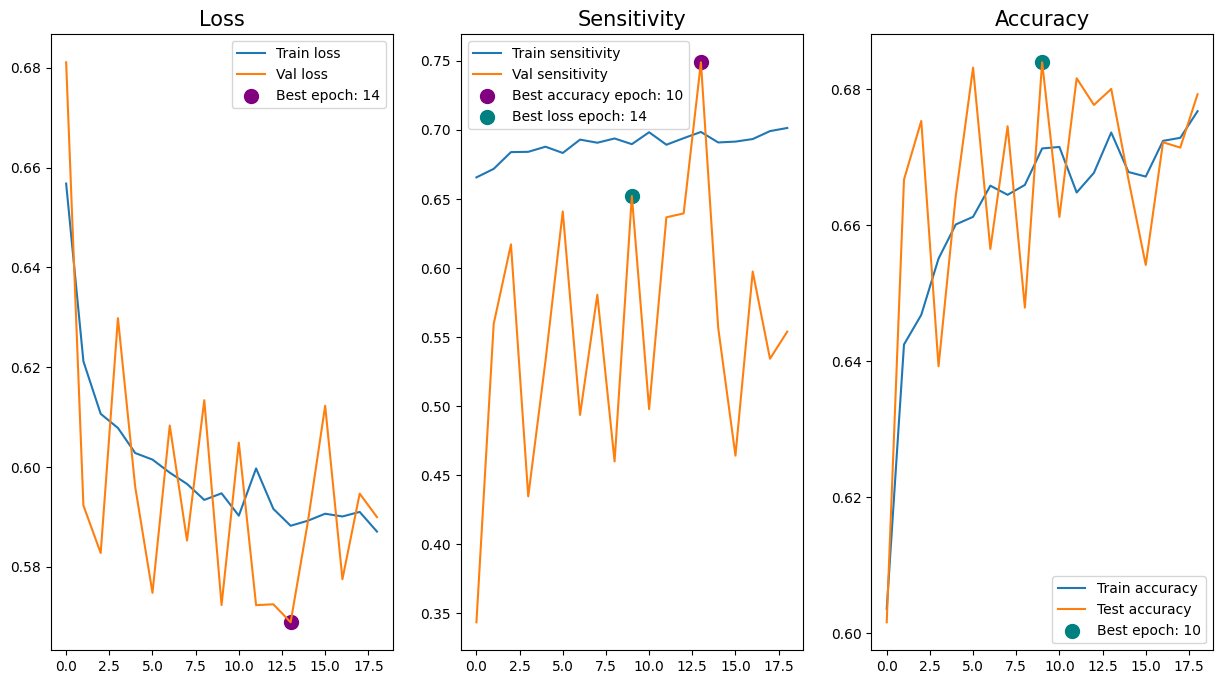

In [ ]:
# calculate sensitivity
train_sensitivity = [i/(i+j) for i, j in zip(res.history['true_positives_8'], res.history['false_negatives_8'])]
val_sensitivity = [i/(i+j) for i, j in zip(res.history['val_true_positives_8'], res.history['val_false_negatives_8'])]

# get epoch with lowest validation loss
index_lowest_loss = np.argmin(res.history['val_loss'])
val_loss_lowest = res.history['val_loss'][index_lowest_loss]
loss_label = f'Best epoch: {str(index_lowest_loss+1)}'

# get epoch with highest validation accuracy
index_highest_acc = np.argmax(res.history['val_acc'])
val_acc_highest = res.history['val_acc'][index_highest_acc]
acc_label = f'Best epoch: {str(index_highest_acc+1)}'

# get sensitivity at lowest validation loss and highest validation accuracy epochs
val_sens_at_high_acc = val_sensitivity[index_highest_acc]
val_sens_at_low_loss = val_sensitivity[index_lowest_loss]
sens_high_label = f'Best accuracy epoch: {str(index_highest_acc+1)}'
sens_low_label = f'Best loss epoch: {str(index_lowest_loss+1)}'

fig, ax = plt.subplots(1, 3, figsize = (15, 8))

ax[0].plot(res.history['loss'], label = 'Train loss')
ax[0].plot(res.history['val_loss'], label = 'Val loss')
ax[0].scatter(index_lowest_loss, val_loss_lowest, s = 100, color = 'purple', label = loss_label)
ax[0].set_title('Loss', size = 15)
ax[0].legend(loc = 'best')

ax[1].plot(train_sensitivity, label = 'Train sensitivity')
ax[1].plot(val_sensitivity, label = 'Val sensitivity')
ax[1].scatter(index_lowest_loss, val_sens_at_low_loss, s = 100, color = 'purple', label = sens_high_label)
ax[1].scatter(index_highest_acc, val_sens_at_high_acc, s = 100, color = 'teal', label = sens_low_label)
ax[1].set_title('Sensitivity', size = 15)
ax[1].legend(loc = 'best')

ax[2].plot(res.history['acc'], label = 'Train accuracy')
ax[2].plot(res.history['val_acc'], label = 'Test accuracy')
ax[2].scatter(index_highest_acc, val_acc_highest, s = 100, color = 'teal', label = acc_label)
ax[2].set_title('Accuracy', size = 15)
ax[2].legend(loc = 'best');

There is a lot of variance in the validation loss and metrics with the entire ResNet152V2 architecture set to untrainable. The next step is to unfreeze some of the top layers so it can learn more about the retinal image dataset.

In [ ]:
base_model.trainable = True
print('Number of layers in the base model: ', len(base_model.layers))

Number of layers in the base model:  564


In [ ]:
# set layer to start fine tuning at
fine_tune_at = 500

# freeze layers before as untrainable
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.075),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000005),
              metrics = ['acc', TruePositives(), FalseNegatives()])

In [ ]:
es = EarlyStopping(patience = 5,
                   restore_best_weights = True)

model_checkpoint = ModelCheckpoint(filepath = 'best_binary_resnet_tuned_model.keras',
                                   monitor = 'val_loss',
                                   save_best_only = True,
                                   mode = 'min')

In [ ]:
model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_6 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_10 (TrueDivide)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_10 (Subtract)               │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet152v2 (Functional)             │ (None, 7, 7, 2048)          │      58,331,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_10          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,333,697 (222.53 MB)

 Trainable params: 18,062,849 (68.90 MB)

 Non-trainable params: 40,270,848 (153.62 MB)

In [ ]:
res_tuned = model.fit(train_ds,
                      epochs = 65,
                      initial_epoch = 14,
                      validation_data = val_ds,
                      callbacks = [es, model_checkpoint])

Epoch 15/65
560/560 ━━━━━━━━━━━━━━━━━━━━ 66s 75ms/step - acc: 0.6084 - false_negatives_9: 708.8378 - loss: 0.8460 - true_positives_9: 1744.1479 - val_acc: 0.6659 - val_false_negatives_9: 257.0000 - val_loss: 0.6152 - val_true_positives_9: 456.0000
Epoch 16/65
560/560 ━━━━━━━━━━━━━━━━━━━━ 34s 60ms/step - acc: 0.6546 - false_negatives_9: 757.8396 - loss: 0.6254 - true_positives_9: 1696.2621 - val_acc: 0.6706 - val_false_negatives_9: 324.0000 - val_loss: 0.6153 - val_true_positives_9: 389.0000
Epoch 17/65
560/560 ━━━━━━━━━━━━━━━━━━━━ 36s 64ms/step - acc: 0.6636 - false_negatives_9: 758.4849 - loss: 0.6134 - true_positives_9: 1693.8734 - val_acc: 0.6690 - val_false_negatives_9: 257.0000 - val_loss: 0.5918 - val_true_positives_9: 456.0000
Epoch 18/65
560/560 ━━━━━━━━━━━━━━━━━━━━ 36s 64ms/step - acc: 0.6874 - false_negatives_9: 728.2727 - loss: 0.5964 - true_positives_9: 1723.9679 - val_acc: 0.6824 - val_false_negatives_9: 253.0000 - val_loss: 0.5844 - val_true_positives_9: 460.0000
Epoch 19

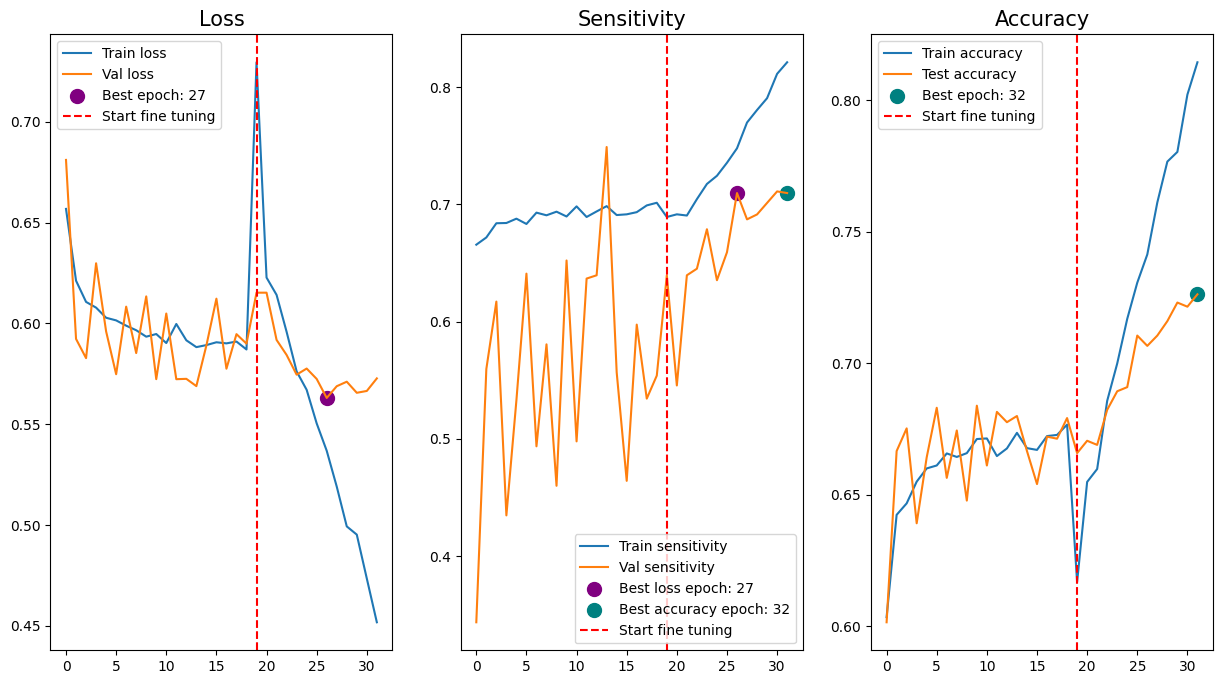

In [ ]:
train_sensitivity = [i/(i+j) for i, j in zip(res.history['true_positives_8']+res_tuned.history['true_positives_9'],
                                             res.history['false_negatives_8']+res_tuned.history['false_negatives_9'])]
val_sensitivity = [i/(i+j) for i, j in zip(res.history['val_true_positives_8']+res_tuned.history['val_true_positives_9'],
                                           res.history['val_false_negatives_8']+res_tuned.history['val_false_negatives_9'])]

# get epoch with lowest validation loss
index_lowest_loss = np.argmin(res_tuned.history['val_loss'])
val_loss_lowest = res_tuned.history['val_loss'][index_lowest_loss]
loss_label = f'Best epoch: {str(index_lowest_loss+20)}'

# get epoch with highest validation accuracy
index_highest_acc = np.argmax(res_tuned.history['val_acc'])
val_acc_highest = res_tuned.history['val_acc'][index_highest_acc]
acc_label = f'Best epoch: {str(index_highest_acc+20)}'

# get sensitivity at lowest validation loss and highest validation accuracy epochs
val_sens_at_high_acc = val_sensitivity[index_highest_acc+19]
val_sens_at_low_loss = val_sensitivity[index_lowest_loss+19]
sens_high_label = f'Best accuracy epoch: {str(index_highest_acc+20)}'
sens_low_label = f'Best loss epoch: {str(index_lowest_loss+20)}'

fig, ax = plt.subplots(1, 3, figsize = (15, 8))

ax[0].plot(res.history['loss']+res_tuned.history['loss'], label = 'Train loss')
ax[0].plot(res.history['val_loss']+res_tuned.history['val_loss'], label = 'Val loss')
ax[0].scatter(index_lowest_loss+19, val_loss_lowest, s = 100, color = 'purple', label = loss_label)
ax[0].axvline(19, color = 'red', linestyle = '--', label = 'Start fine tuning')
ax[0].set_title('Loss', size = 15)
ax[0].legend(loc = 'best')

ax[1].plot(train_sensitivity, label = 'Train sensitivity')
ax[1].plot(val_sensitivity, label = 'Val sensitivity')
ax[1].scatter(index_lowest_loss+19, val_sens_at_low_loss, s = 100, color = 'purple', label = sens_low_label)
ax[1].scatter(index_highest_acc+19, val_sens_at_high_acc, s = 100, color = 'teal', label = sens_high_label)
ax[1].axvline(19, color = 'red', linestyle = '--', label = 'Start fine tuning')
ax[1].set_title('Sensitivity', size = 15)
ax[1].legend(loc = 'best')

ax[2].plot(res.history['acc']+res_tuned.history['acc'], label = 'Train accuracy')
ax[2].plot(res.history['val_acc']+res_tuned.history['val_acc'], label = 'Test accuracy')
ax[2].scatter(index_highest_acc+19, val_acc_highest, s = 100, color = 'teal', label = acc_label)
ax[2].axvline(19, color = 'red', linestyle = '--', label = 'Start fine tuning')
ax[2].set_title('Accuracy', size = 15)
ax[2].legend(loc = 'best');

The variance in the validation metrics is smoothed out by slowing the learning rate and implementing label smoothing in the binary crossentropy loss function, but still overfits fairly quickly. After several iterations with and without the data augmentation and trialing different layers to at which to freeze the pretained model I wasn't seeing much improvement with this model.

Next I'm going to try transfer learning with the Xception pretrained Keras model. I'm reloading in the dataset with image size (299, 299, 3) as the default size for Xception. I will be using the same image augmentation methods as in the ResNet152V2 model.

In [ ]:
# load in images as train and validation sets with image size (299, 299)
train_xcept_ds, val_xcept_ds = image_dataset_from_directory(
    'binary',
    image_size = (299, 299),
    batch_size = 16,
    label_mode = 'binary',
    seed = 42,
    validation_split = 0.3,
    subset = 'both',
)

# split validation into val and test sets
val_batches = tf.data.experimental.cardinality(val_xcept_ds)
test_xcept_ds = val_xcept_ds.take((2*val_batches) // 3)
val_xcept_ds = val_xcept_ds.skip((2*val_batches) // 3)

Found 12784 files belonging to 2 classes.
Using 8949 files for training.
Using 3835 files for validation.


In [ ]:
base_model = Xception(input_shape = (299, 299, 3),
                      include_top = False,
                      weights = 'imagenet')

image_batch, label_batch = next(iter(train_xcept_ds))
feature_batch = base_model(image_batch)

base_model.trainable = False

In [ ]:
data_augmentation = Sequential([
    RandomRotation(0.1, seed = 42),
    RandomContrast(0.1, seed = 42)
])

In [ ]:
global_average_layer = GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
prediction_layer = Dense(1, activation = 'sigmoid')
prediction_batch = prediction_layer(feature_batch_average)

inputs = tf.keras.Input(shape=(299, 299, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)
x = Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)          │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_5 (Sequential)            │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_9 (TrueDivide)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_9 (Subtract)                │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
model.compile(loss = 'bce', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              metrics = ['acc', TruePositives(), FalseNegatives()])

In [ ]:
es = EarlyStopping(patience = 7,
                   restore_best_weights = True)

model_checkpoint = ModelCheckpoint(filepath = 'best_binary_xception_model.keras',
                                   monitor = 'val_loss',
                                   save_best_only = True,
                                   mode = 'min')

In [ ]:
res = model.fit(train_xcept_ds,
                epochs = 50,
                validation_data = val_xcept_ds,
                callbacks = [es, model_checkpoint])

Epoch 1/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - acc: 0.5836 - false_negatives_6: 775.7682 - loss: 0.6580 - true_positives_6: 1676.3547 - val_acc: 0.6518 - val_false_negatives_6: 265.0000 - val_loss: 0.6113 - val_true_positives_6: 448.0000
Epoch 2/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - acc: 0.6361 - false_negatives_6: 779.8021 - loss: 0.6143 - true_positives_6: 1672.8057 - val_acc: 0.6627 - val_false_negatives_6: 205.0000 - val_loss: 0.5929 - val_true_positives_6: 508.0000
Epoch 3/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - acc: 0.6582 - false_negatives_6: 772.6702 - loss: 0.5979 - true_positives_6: 1680.0642 - val_acc: 0.6502 - val_false_negatives_6: 357.0000 - val_loss: 0.6064 - val_true_positives_6: 356.0000
Epoch 4/50
560/560 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - acc: 0.6615 - false_negatives_6: 777.7219 - loss: 0.5938 - true_positives_6: 1674.6471 - val_acc: 0.6761 - val_false_negatives_6: 265.0000 - val_loss: 0.5863 - val_true_positives_6: 448.0000
Epoch 5/50
5

In [ ]:
res.history

{'acc': [0.6071069240570068,
  0.6453235149383545,
  0.6578388810157776,
  0.6670019030570984,
  0.667448878288269,
  0.6685663461685181,
  0.6702424883842468,
  0.6720303893089294,
  0.6794055104255676,
  0.6778411269187927,
  0.6828696131706238,
  0.6778411269187927,
  0.6824226379394531,
  0.678958535194397,
  0.6773941516876221,
  0.6799642443656921,
  0.6849927306175232,
  0.6810817122459412,
  0.6813051700592041,
  0.6881215572357178,
  0.6804112195968628,
  0.6794055104255676,
  0.683987021446228,
  0.6868923902511597,
  0.6833165884017944,
  0.6855514645576477,
  0.6799642443656921],
 'false_negatives_6': [1575.0,
  1548.0,
  1536.0,
  1522.0,
  1561.0,
  1501.0,
  1472.0,
  1484.0,
  1486.0,
  1474.0,
  1454.0,
  1463.0,
  1451.0,
  1470.0,
  1444.0,
  1461.0,
  1432.0,
  1458.0,
  1473.0,
  1422.0,
  1442.0,
  1453.0,
  1457.0,
  1426.0,
  1449.0,
  1470.0,
  1485.0],
 'loss': [0.6397809982299805,
  0.6094512939453125,
  0.5988343954086304,
  0.5886018872261047,
  0.590064823

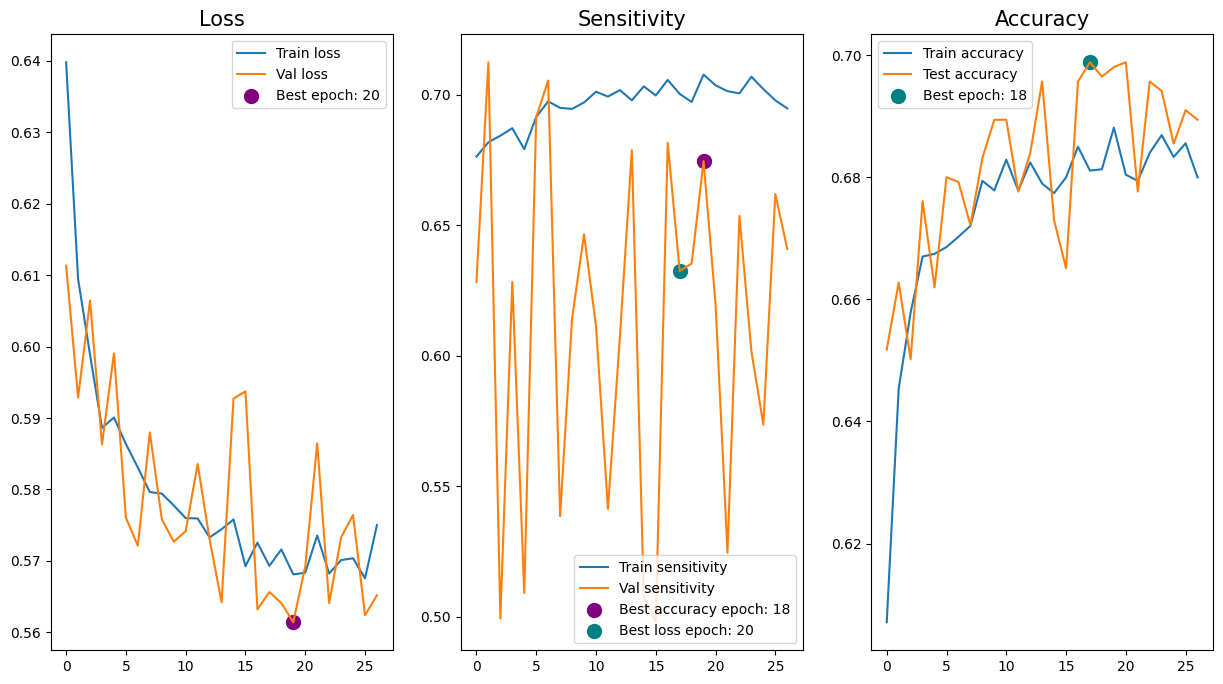

In [ ]:
train_sensitivity = [i/(i+j) for i, j in zip(res.history['true_positives_6'], res.history['false_negatives_6'])]
val_sensitivity = [i/(i+j) for i, j in zip(res.history['val_true_positives_6'], res.history['val_false_negatives_6'])]

# get epoch with lowest validation loss
index_lowest_loss = np.argmin(res.history['val_loss'])
val_loss_lowest = res.history['val_loss'][index_lowest_loss]
loss_label = f'Best epoch: {str(index_lowest_loss+1)}'

# get epoch with highest validation accuracy
index_highest_acc = np.argmax(res.history['val_acc'])
val_acc_highest = res.history['val_acc'][index_highest_acc]
acc_label = f'Best epoch: {str(index_highest_acc+1)}'

# get sensitivity at lowest validation loss and highest validation accuracy epochs
val_sens_at_high_acc = val_sensitivity[index_highest_acc]
val_sens_at_low_loss = val_sensitivity[index_lowest_loss]
sens_high_label = f'Best accuracy epoch: {str(index_highest_acc+1)}'
sens_low_label = f'Best loss epoch: {str(index_lowest_loss+1)}'

fig, ax = plt.subplots(1, 3, figsize = (15, 8))

ax[0].plot(res.history['loss'], label = 'Train loss')
ax[0].plot(res.history['val_loss'], label = 'Val loss')
ax[0].scatter(index_lowest_loss, val_loss_lowest, s = 100, color = 'purple', label = loss_label)
ax[0].set_title('Loss', size = 15)
ax[0].legend(loc = 'best')

ax[1].plot(train_sensitivity, label = 'Train sensitivity')
ax[1].plot(val_sensitivity, label = 'Val sensitivity')
ax[1].scatter(index_lowest_loss, val_sens_at_low_loss, s = 100, color = 'purple', label = sens_high_label)
ax[1].scatter(index_highest_acc, val_sens_at_high_acc, s = 100, color = 'teal', label = sens_low_label)
ax[1].set_title('Sensitivity', size = 15)
ax[1].legend(loc = 'best')

ax[2].plot(res.history['acc'], label = 'Train accuracy')
ax[2].plot(res.history['val_acc'], label = 'Test accuracy')
ax[2].scatter(index_highest_acc, val_acc_highest, s = 100, color = 'teal', label = acc_label)
ax[2].set_title('Accuracy', size = 15)
ax[2].legend(loc = 'best');

Using only ImageNet weights through Xception we see a slightly lower loss and higher accuracy than with ResNet152V2. Next we'll see how Xception does with unfreezing some layers and training it with the retinal image data.

In [ ]:
base_model.trainable = True
print('Number of layers in the base model: ', len(base_model.layers))

Number of layers in the base model:  132


In [ ]:
# set layer to start fine tuning at
fine_tune_at = 100

# freeze layers before as untrainable
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.075),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000005),
              metrics = ['acc', TruePositives(), FalseNegatives()])

In [ ]:
es = EarlyStopping(patience = 7,
                   restore_best_weights = True)

model_checkpoint = ModelCheckpoint(filepath = 'best_binary_xception_tuned_model.keras',
                                   monitor = 'val_loss',
                                   save_best_only = True,
                                   mode = 'min')

In [ ]:
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)          │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_5 (Sequential)            │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_9 (TrueDivide)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_9 (Subtract)                │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 9,480,393 (36.16 MB)

 Non-trainable params: 11,383,136 (43.42 MB)

In [ ]:
res_tuned = model.fit(train_xcept_ds,
                      epochs = 70,
                      initial_epoch = 20,
                      validation_data = val_xcept_ds,
                      callbacks = [es, model_checkpoint])

Epoch 21/70
560/560 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step - acc: 0.5947 - false_negatives_7: 439.8004 - loss: 0.7784 - true_positives_7: 2013.3939 - val_acc: 0.6620 - val_false_negatives_7: 298.0000 - val_loss: 0.6144 - val_true_positives_7: 415.0000
Epoch 22/70
560/560 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - acc: 0.6480 - false_negatives_7: 757.7914 - loss: 0.6294 - true_positives_7: 1696.5134 - val_acc: 0.6784 - val_false_negatives_7: 245.0000 - val_loss: 0.5931 - val_true_positives_7: 468.0000
Epoch 23/70
560/560 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - acc: 0.6634 - false_negatives_7: 764.6917 - loss: 0.6137 - true_positives_7: 1687.6560 - val_acc: 0.6949 - val_false_negatives_7: 244.0000 - val_loss: 0.5863 - val_true_positives_7: 469.0000
Epoch 24/70
560/560 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - acc: 0.6741 - false_negatives_7: 739.9251 - loss: 0.6054 - true_positives_7: 1713.0303 - val_acc: 0.7027 - val_false_negatives_7: 238.0000 - val_loss: 0.5795 - val_true_positives_7: 475.0000
Epoch 25

In [ ]:
res_tuned.history

{'acc': [0.6157112717628479,
  0.6551570296287537,
  0.6686780452728271,
  0.6792937517166138,
  0.6876745820045471,
  0.7026483416557312,
  0.7160576581954956,
  0.7220918536186218,
  0.7405296564102173,
  0.7387417554855347,
  0.7441054582595825,
  0.7590792179107666,
  0.7674600481987,
  0.7756173610687256,
  0.7734942436218262,
  0.7789697051048279,
  0.7863448262214661,
  0.793943464756012,
  0.7991954684257507,
  0.8051179051399231,
  0.8081349730491638,
  0.8184154629707336,
  0.8227735161781311,
  0.8330539464950562,
  0.8329422473907471,
  0.8319365382194519],
 'false_negatives_7': [1093.0,
  1490.0,
  1492.0,
  1461.0,
  1441.0,
  1381.0,
  1352.0,
  1290.0,
  1239.0,
  1247.0,
  1212.0,
  1164.0,
  1094.0,
  1077.0,
  1099.0,
  1050.0,
  1053.0,
  959.0,
  947.0,
  940.0,
  902.0,
  884.0,
  861.0,
  788.0,
  774.0,
  783.0],
 'loss': [0.6925167441368103,
  0.6249005198478699,
  0.6084967851638794,
  0.5990084409713745,
  0.5882312059402466,
  0.5748913288116455,
  0.5665696

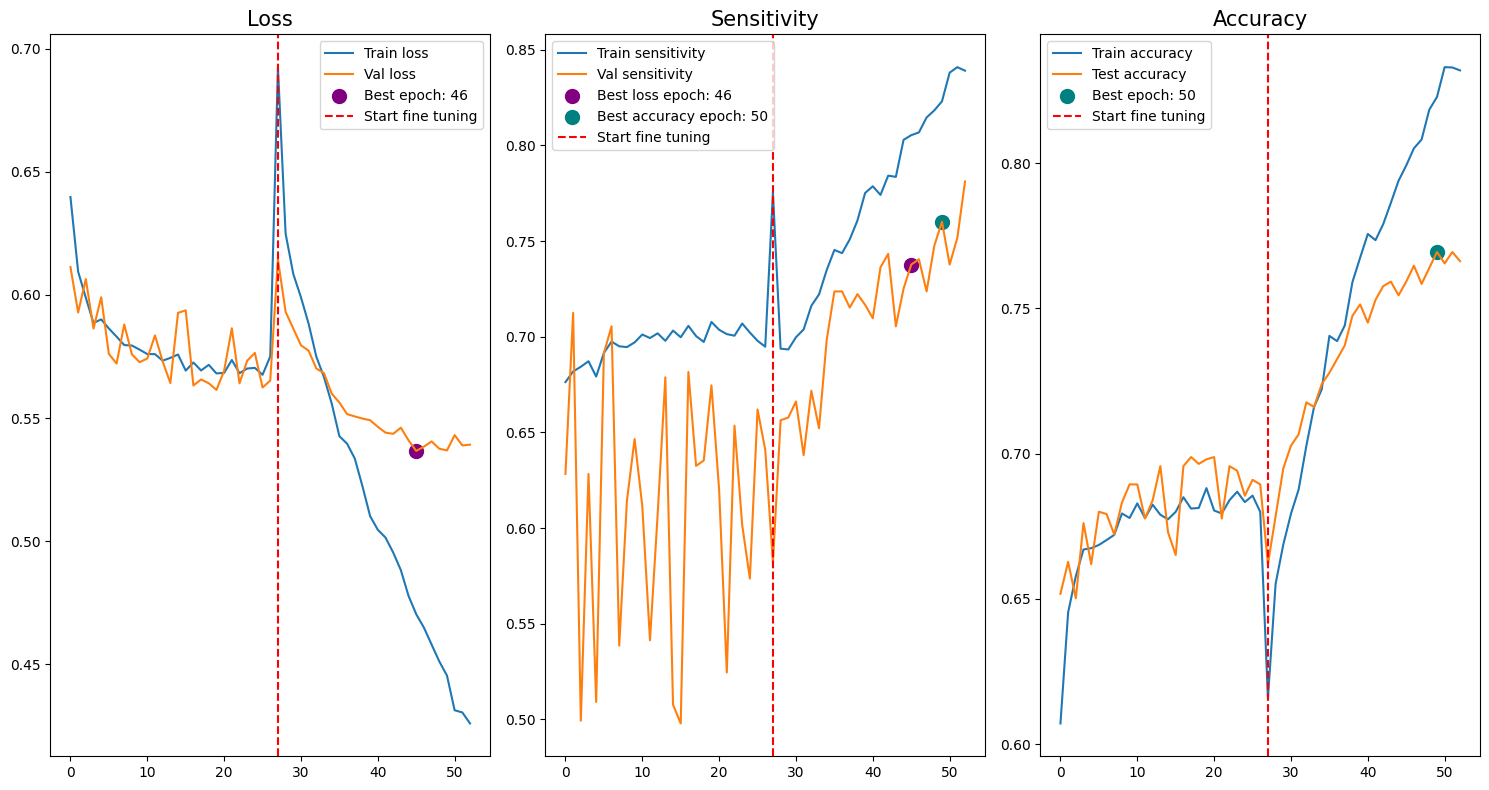

In [ ]:
train_sensitivity = [i/(i+j) for i, j in zip(res.history['true_positives_6']+res_tuned.history['true_positives_7'],
                                             res.history['false_negatives_6']+res_tuned.history['false_negatives_7'])]
val_sensitivity = [i/(i+j) for i, j in zip(res.history['val_true_positives_6']+res_tuned.history['val_true_positives_7'],
                                           res.history['val_false_negatives_6']+res_tuned.history['val_false_negatives_7'])]

# get epoch with lowest validation loss
index_lowest_loss = np.argmin(res_tuned.history['val_loss'])
val_loss_lowest = res_tuned.history['val_loss'][index_lowest_loss]
loss_label = f'Best epoch: {str(index_lowest_loss+28)}'

# get epoch with highest validation accuracy
index_highest_acc = np.argmax(res_tuned.history['val_acc'])
val_acc_highest = res_tuned.history['val_acc'][index_highest_acc]
acc_label = f'Best epoch: {str(index_highest_acc+28)}'

# get sensitivity at lowest validation loss and highest validation accuracy epochs
val_sens_at_high_acc = val_sensitivity[index_highest_acc+27]
val_sens_at_low_loss = val_sensitivity[index_lowest_loss+27]
sens_high_label = f'Best accuracy epoch: {str(index_highest_acc+28)}'
sens_low_label = f'Best loss epoch: {str(index_lowest_loss+28)}'

fig, ax = plt.subplots(1, 3, figsize = (15, 8))

ax[0].plot(res.history['loss']+res_tuned.history['loss'], label = 'Train loss')
ax[0].plot(res.history['val_loss']+res_tuned.history['val_loss'], label = 'Val loss')
ax[0].scatter(index_lowest_loss+27, val_loss_lowest, s = 100, color = 'purple', label = loss_label)
ax[0].axvline(27, color = 'red', linestyle = '--', label = 'Start fine tuning')
ax[0].set_title('Loss', size = 15)
ax[0].legend(loc = 'best')

ax[1].plot(train_sensitivity, label = 'Train sensitivity')
ax[1].plot(val_sensitivity, label = 'Val sensitivity')
ax[1].scatter(index_lowest_loss+27, val_sens_at_low_loss, s = 100, color = 'purple', label = sens_low_label)
ax[1].scatter(index_highest_acc+27, val_sens_at_high_acc, s = 100, color = 'teal', label = sens_high_label)
ax[1].axvline(27, color = 'red', linestyle = '--', label = 'Start fine tuning')
ax[1].set_title('Sensitivity', size = 15)
ax[1].legend(loc = 'best')

ax[2].plot(res.history['acc']+res_tuned.history['acc'], label = 'Train accuracy')
ax[2].plot(res.history['val_acc']+res_tuned.history['val_acc'], label = 'Test accuracy')
ax[2].scatter(index_highest_acc+27, val_acc_highest, s = 100, color = 'teal', label = acc_label)
ax[2].axvline(27, color = 'red', linestyle = '--', label = 'Start fine tuning')
ax[2].set_title('Accuracy', size = 15)
ax[2].legend(loc = 'best')

# saving image for presentation
plt.tight_layout()
plt.savefig('best_model_performance.png');

After fine tuning where to start the unfrozen layer, the model using transfer learning with Xception doesn't overfit quite as quickly as ResNet152V2. It also achieves a lower loss and higher sensitivity and accuracy. I did leave the model checkpoint to save the model at the epoch with the lowest validation loss because in most iterations the highest sensitivity was achieved in that same epoch as opposed to the epoch with the highest accuracy, that just wasn't the case in this final iteration.

In [ ]:
print(f'Train Accuracy :{round(res_tuned.history["acc"][index_lowest_loss]*100, 2)}%')
print(f'Train Sensitivity :{round(train_sensitivity[index_lowest_loss+27]*100, 2)}%')
print(f'Val Accuracy :{round(res_tuned.history["val_acc"][index_lowest_loss]*100, 2)}%')
print(f'Val Sensitivity :{round(val_sensitivity[index_lowest_loss+27]*100, 2)}%')

Train Accuracy :79.92%
Train Sensitivity :80.54%
Val Accuracy :75.92%
Val Sensitivity :73.77%


In [ ]:
model.evaluate(test_xcept_ds, verbose = 2)

160/160 - 3s - 20ms/step - acc: 0.7477 - false_negatives_7: 379.0000 - loss: 0.5333 - true_positives_7: 1080.0000


[0.5332977175712585, 0.7476562261581421, 1080.0, 379.0]

In [ ]:
loss, accuracy, tp, fn = model.evaluate(test_xcept_ds)
print(f'Test Accuracy :{round(accuracy*100, 2)}%')
print(f'Test Sensitivity :{round((tp/(tp+fn))*100, 2)}%')

160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - acc: 0.7323 - false_negatives_7: 195.2981 - loss: 0.5501 - true_positives_7: 549.5714
Test Accuracy :74.77%
Test Sensitivity :74.02%


Predictions:
[1 0 1 1 1 1 1 0 0 0 1 1 0 0 1 0]
Labels:
[1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1.]


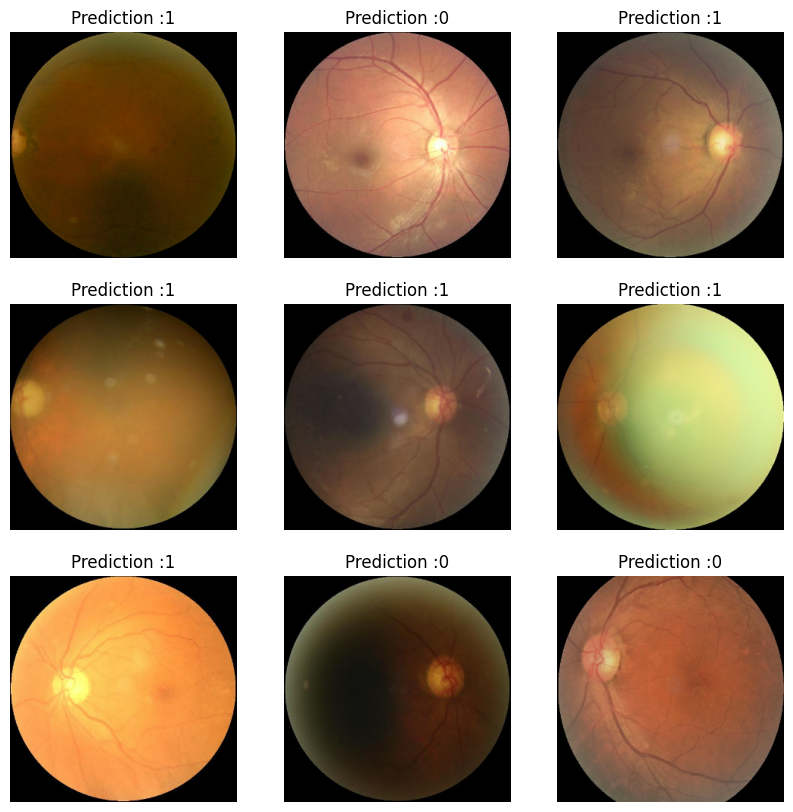

In [ ]:
# visualize a few predictions
# method below also followed from tensorflow transfer learning tutorial
class_names = train_xcept_ds.class_names
image_batch, label_batch = test_xcept_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print(f'Predictions:\n{predictions.numpy()}')
print(f'Labels:\n{label_batch.flatten()}')

plt.figure(figsize = (10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image_batch[i].astype('uint8'))
  plt.title(f'Prediction: {class_names[predictions[i]]}')
  plt.axis('off')

# save image for presentation slides
plt.savefig('predictions_visual.png')

In [ ]:
pred_probas = model.predict(test_xcept_ds).flatten()
pred_probas

160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


array([0.98993826, 0.29780987, 0.91935545, ..., 0.36427426, 0.65688014,
       0.6122237 ], dtype=float32)

In [ ]:
preds = np.array([1 if x >= 0.5 else 0 for x in pred_probas])

In [ ]:
preds

array([1, 0, 1, ..., 0, 1, 1])

In [ ]:
# method to get labels in test set followed with stack overflow example
# https://stackoverflow.com/questions/64687375/get-labels-from-dataset-when-using-tensorflow-image-dataset-from-directory
preds = np.array([])
labels = np.array([])

for i, j in test_xcept_ds:
  preds = np.concatenate([preds, np.argmax(model.predict(i), axis = -1)])
  labels = np.concatenate([labels, np.argmax(j.numpy(), axis = -1)])

preds = preds.astype(int)
labels = labels.astype(int)

In [ ]:
# method to get labels in test set followed with stack overflow example
# https://stackoverflow.com/questions/64687375/get-labels-from-dataset-when-using-tensorflow-image-dataset-from-directory
test_labels = np.concatenate([y for x, y in test_xcept_ds], axis = 0).flatten()
test_labels.astype(int)

array([1, 0, 1, ..., 0, 1, 1])

In [ ]:
print(f'ROC-AUC score: {roc_auc_score(test_labels, preds)}')

ROC-AUC score: 0.7488631121685749


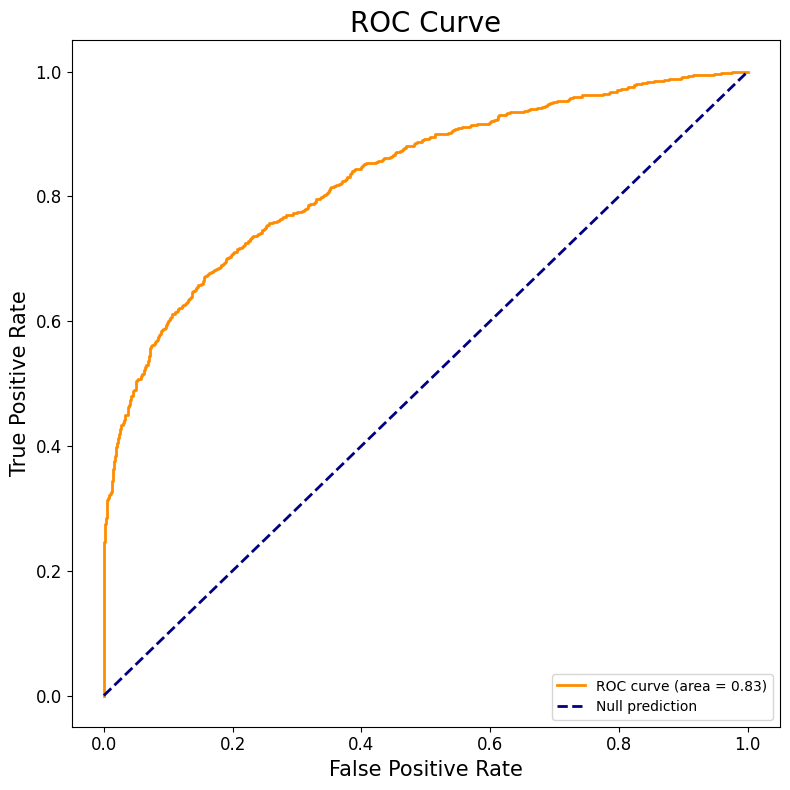

In [ ]:
# follow method described by Google AI to plot ROC curve with CNN model
fpr, tpr, threshold = roc_curve(test_labels, pred_probas)

roc_auc = auc(fpr, tpr)

plt.figure(figsize = (8, 8))
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (area = %0.2f)'% roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--', label = 'Null prediction')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', size = 15)
plt.ylabel('True Positive Rate', size = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('ROC Curve', size = 20)
plt.legend(loc = 'lower right')

# save image for presentation slides
plt.tight_layout()
plt.savefig('roc_curve.png');

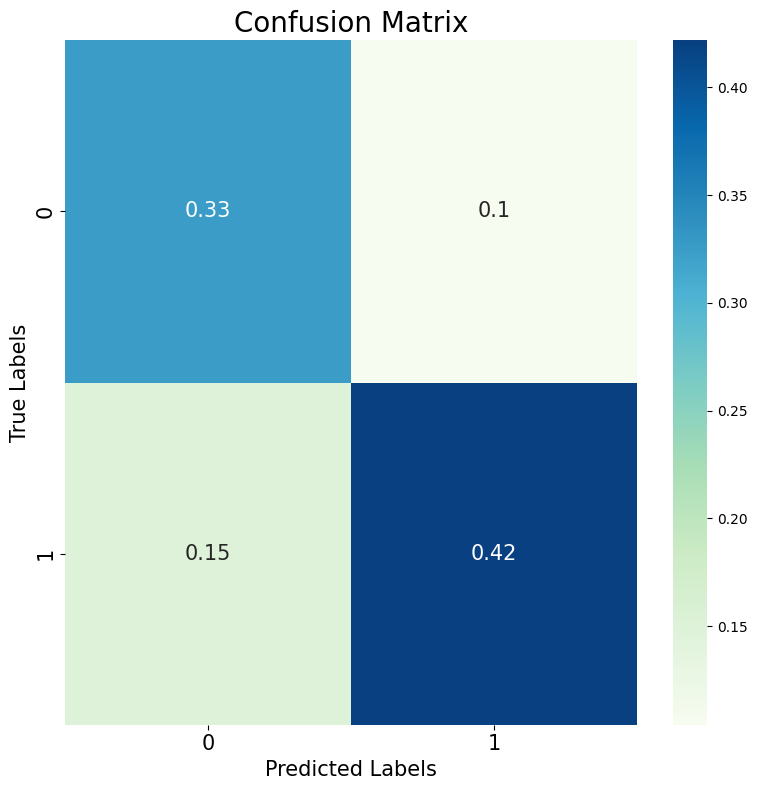

In [ ]:
cm = confusion_matrix(test_labels, preds, normalize = 'all')

plt.figure(figsize = (8, 8))
disp = sns.heatmap(cm, annot = True, annot_kws={'size': 15}, cmap = 'GnBu')
plt.xlabel('Predicted Labels', size = 15)
plt.ylabel('True Labels', size = 15)
plt.title('Confusion Matrix', size = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

# save image for presentation slides
plt.tight_layout()
plt.savefig('confusion_matrix.png');

---
## Conclusions

The final tuned Xception model achieved a validation accuracy of 75.92% and a test accuracy of 74.77%. However, these metrics fall short of the production-ready threshold of 80% accuracy. While the model demonstrates some discriminatory power by improving over the baseline accuracy of 55%, the test set sensitivity of 74.02% is concerning, as the production-ready threshold of 95% sensitivity is critical for minimizing false negatives in retinal disease detection.

Some possible next steps:
* Utilize additional data augmentation techniques.
* Experiment with other pretrained architectures, I only looked at two in this project.
* Start fine-tuning deeper layers in Xception to better adapt to the the specific dataset, and explore additional regularization techniques to prevent overfitting.
* Tune hyperparameters such as learning rate and optimizers to help mitigate overfitting.
* Explore other preprocessing techniques to highlight regions specific to fundus images.
* Try combining multiple pretrained models.

If production-level performance is able to be reached for the binary classification using further tuning and additional techniques, only then would I utilize transfer learning and build a multiclass model to predict the specific disease classes. 